In [1]:
# importovanje biblioteka koje ce nam biti potrebne kasnije
import numpy as np
import pandas as pd 
import time
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
import shap

In [2]:
X_sm=pd.read_csv('D:\\Vlada\\Milica master\\X_sm.csv')
y_sm=pd.read_csv('D:\\Vlada\\Milica master\\y_sm.csv')
X_test=pd.read_csv('D:\\Vlada\\Milica master\\X_test.csv')
y_test=pd.read_csv('D:\\Vlada\\Milica master\\y_test.csv')

In [3]:
X_test.shape

(61503, 198)

In [4]:
X_test.head()

,CNT_CHILDREN,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Self-employed,FONDKAPREMONT_MODE_reg oper account,HOUSETYPE_MODE_block of flats,WALLSMATERIAL_MODE_Panel
0,0.811107,0.424493,-0.774242,0.578409,-0.451414,0.599675,-0.933419,-0.499501,-0.625067,-0.102783,...,-0.181934,-0.254312,2.135034,-0.083318,-0.533061,-0.149796,-0.376706,-0.561977,-0.979671,-0.523103
1,-0.578749,-0.582140,-0.977863,-0.388159,-0.485614,0.095214,1.150423,-0.499501,-0.625067,-0.102783,...,-0.181934,-0.254312,2.135034,-0.083318,-0.533061,-0.149796,-0.376706,-0.561977,-0.979671,-0.523103
2,-0.578749,-0.782018,-0.462197,-1.872736,-0.459112,-2.134007,0.344865,-0.499501,1.599829,-0.102783,...,-0.181934,-0.254312,-0.468377,-0.083318,-0.533061,-0.149796,-0.376706,-0.561977,1.020751,1.911670
3,-0.578749,0.937050,-0.010501,1.462232,-0.453186,1.140737,0.467522,2.001999,-0.625067,1.862347,...,-0.181934,-0.254312,-0.468377,-0.083318,-0.533061,-0.149796,2.654589,-0.561977,-0.979671,-0.523103
4,-0.578749,-0.685688,1.079452,-0.334066,-0.460352,-1.439450,1.295622,-0.499501,-0.625067,-0.102783,...,-0.181934,-0.254312,2.135034,-0.083318,-0.533061,-0.149796,-0.376706,-0.561977,-0.979671,-0.523103


## Logisticka regresija

In [5]:
#koristicemo funkciju SelectKBest da bismo izabrali najbolje varijable
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X_sm,y_sm)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_sm.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(10,'Score')) 

                                                 Specs         Score
15                                        EXT_SOURCE_3  43066.721899
14                                        EXT_SOURCE_2  42988.396618
23                             bureau_DAYS_CREDIT_mean  14924.698600
3                                           DAYS_BIRTH  11380.688194
25                              bureau_DAYS_CREDIT_min  10353.414042
35                      bureau_DAYS_CREDIT_UPDATE_mean  10182.333923
181               NAME_EDUCATION_TYPE_Higher education  10179.391211
40              bureau_CREDIT_ACTIVE_Closed_count_norm   9599.535920
31                       bureau_DAYS_ENDDATE_FACT_mean   9471.610067
182  NAME_EDUCATION_TYPE_Secondary / secondary special   8488.672227


In [6]:
#trazimo najbolji regularizacioni parametar 
grid_model = LogisticRegression()
params = {'C': [10**i for i in range(-5, 5)]}
grid = model_selection.GridSearchCV(grid_model, param_grid=params, scoring='roc_auc', cv=5, return_train_score=True)

In [7]:
grid.fit(X_sm[featureScores.nlargest(10,'Score')['Specs']], y_sm)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000]},
             return_train_score=True, scoring='roc_auc')

In [8]:
grid.best_params_

{'C': 100}

In [9]:
log_reg = LogisticRegression(C = 100)

# Treniramo model na trening setu
log_reg.fit(X_sm, y_sm)

LogisticRegression(C=100)

In [10]:
log_reg_pred = log_reg.predict_proba(X_test)
log_reg_pred

array([[0.64871569, 0.35128431],
       [0.57678364, 0.42321636],
       [0.37463769, 0.62536231],
       ...,
       [0.79850979, 0.20149021],
       [0.33095724, 0.66904276],
       [0.46228565, 0.53771435]])

In [11]:
predicted = log_reg.predict(X_sm)
report = classification_report(y_sm, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.70      0.71    226148
           1       0.71      0.73      0.72    226148

    accuracy                           0.72    452296
   macro avg       0.72      0.72      0.72    452296
weighted avg       0.72      0.72      0.72    452296



In [12]:
predicted = log_reg.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     56538
           1       0.17      0.68      0.27      4965

    accuracy                           0.70     61503
   macro avg       0.57      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503



In [13]:
confusion_matrix(y_test, predicted)

array([[39916, 16622],
       [ 1595,  3370]], dtype=int64)

In [14]:
valid_auc = roc_auc_score(y_test, predicted)

In [15]:
valid_auc

0.6923771505066934

## Slucajna suma

In [16]:
#algoritam slucajne sume, parametri 100 stabala, n_jobs=-1 znaci da koristi sve procesore
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42, verbose = 1, n_jobs = -1)

In [17]:
#treniramo model
random_forest.fit(X_sm, y_sm)
features = list(X_sm.columns)
#izvlacimo najbitnije varijable
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

#predikcija na test setu
predictions = random_forest.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


In [18]:
predictions = random_forest.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


In [19]:
predicted_rf = random_forest.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


In [20]:
report_rf=classification_report(y_test,predicted_rf)
print(report_rf)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.42      0.02      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.67      0.51      0.49     61503
weighted avg       0.88      0.92      0.88     61503



In [21]:
valid_auc_rf = roc_auc_score(y_test, predictions)

In [22]:
valid_auc_rf

0.7333258933016453

In [23]:
def plot_feature_importances(df):
    
    #sortiranje varijabli po znacaju
    df = df.sort_values('importance', ascending = False).reset_index()
    
    #Normalizujemo varijable da bi im suma bila 1
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    #bar chart
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    plt.xlabel('Normalizovan doprinos varijable'); plt.title('Znacajnost varijabli')
    plt.show()
    
    return df

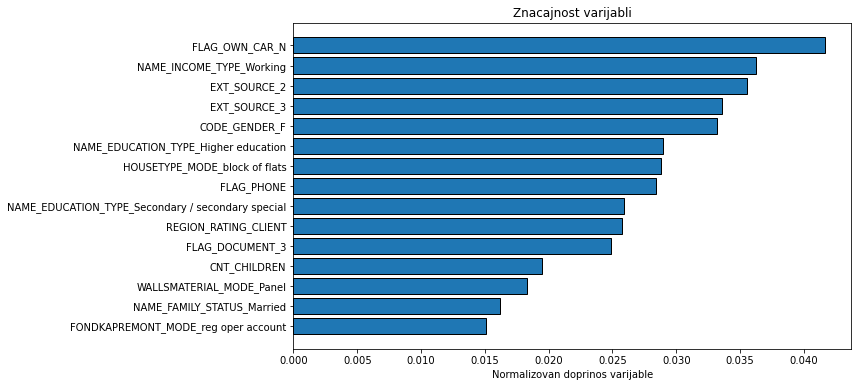

In [24]:
feature_importances_sorted = plot_feature_importances(feature_importances)

In [25]:
confusion_matrix(y_test, predicted_rf)

array([[56425,   113],
       [ 4883,    82]], dtype=int64)

## XGBoost

In [26]:
#Parametri za XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [27]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Vreme utroseno %i sati %i minuta i %s sekundi.' % (thour, tmin, round(tsec, 2)))

In [28]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(estimator=XGBClassifier(objective='binary:logistic'), param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_sm,y_sm), verbose=3, random_state=1001 )

start_time = timer(None)
random_search.fit(X_sm, y_sm)
timer(start_time)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 15.2min finished


[18:17:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Vreme utroseno 0 sati 16 minuta i 31.25 sekundi.


In [29]:
print('\n Rezultati:')
print(random_search.cv_results_)
print('\n Najbolji prediktor:')
print(random_search.best_estimator_)
print('\n Najbolji parametri:')
print(random_search.best_params_)


 Rezultati:
{'mean_fit_time': array([204.25550699, 262.97255135, 247.04319008, 231.08266362,
       206.09758345]), 'std_fit_time': array([ 0.27455613, 14.5566985 ,  4.26788054,  4.46795201,  3.61157948]), 'mean_score_time': array([2.07877453, 2.06979251, 2.33415238, 2.00827479, 1.19399333]), 'std_score_time': array([0.04123664, 0.50257872, 0.60112153, 0.11310221, 0.38138079]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_value

In [30]:
xgb_model =XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=5, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb_model.fit(X_sm, y_sm, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)

[0]	validation_0-auc:0.65089
[1]	validation_0-auc:0.69034
[2]	validation_0-auc:0.69303
[3]	validation_0-auc:0.69790
[4]	validation_0-auc:0.70164
[5]	validation_0-auc:0.70204
[6]	validation_0-auc:0.70177
[7]	validation_0-auc:0.70279
[8]	validation_0-auc:0.70556
[9]	validation_0-auc:0.70767
[10]	validation_0-auc:0.71123
[11]	validation_0-auc:0.71096
[12]	validation_0-auc:0.71096
[13]	validation_0-auc:0.71393
[14]	validation_0-auc:0.71717
[15]	validation_0-auc:0.71755
[16]	validation_0-auc:0.71900
[17]	validation_0-auc:0.71962
[18]	validation_0-auc:0.72291
[19]	validation_0-auc:0.72412
[20]	validation_0-auc:0.72542
[21]	validation_0-auc:0.72598
[22]	validation_0-auc:0.72664
[23]	validation_0-auc:0.72950
[24]	validation_0-auc:0.73164
[25]	validation_0-auc:0.73343
[26]	validation_0-auc:0.73459
[27]	validation_0-auc:0.73598
[28]	validation_0-auc:0.73738
[29]	validation_0-auc:0.73861
[30]	validation_0-auc:0.73950
[31]	validation_0-auc:0.74042
[32]	validation_0-auc:0.74161
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
predictions = xgb_model.predict_proba(X_test)[:, 1]

In [32]:
xgboost_roc_auc = roc_auc_score(y_test, predictions)

In [33]:
predicted_xgb = xgb_model.predict(X_test)

In [34]:
report_xgb=classification_report(y_test,predicted_xgb)
print(report_xgb)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.47      0.04      0.07      4965

    accuracy                           0.92     61503
   macro avg       0.70      0.52      0.51     61503
weighted avg       0.89      0.92      0.89     61503



In [35]:
xgboost_roc_auc

0.7645629758872795

In [36]:
#izvlacimo najbitnije varijable
feature_importance_values = xgb_model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

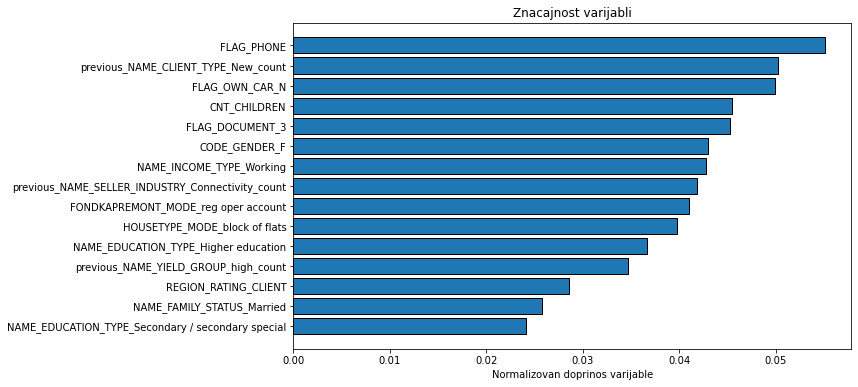

In [37]:
feature_importances_sorted = plot_feature_importances(feature_importances)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


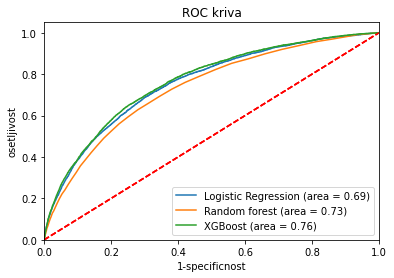

In [38]:
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, random_forest.predict_proba(X_test)[:,1])
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr_rf, tpr_rf, label='Random forest (area = %0.2f)' % valid_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (area = %0.2f)' % xgboost_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-specificnost')
plt.ylabel('osetljivost')
plt.title('ROC kriva')
plt.legend(loc="lower right")
plt.show()


## Interpretabilnost

In [44]:
explainer = shap.TreeExplainer(xgb_model,X_sm,model_output='probability')
shap_values = explainer.shap_values(X_sm)

100%|===================| 452251/452296 [18:46<00:00]        

In [40]:
xgb_model.predict_proba(np.array(X_sm.iloc[1,:]).reshape((1,-1)))

array([[0.9417497 , 0.05825028]], dtype=float32)

In [45]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sm.iloc[0,:])

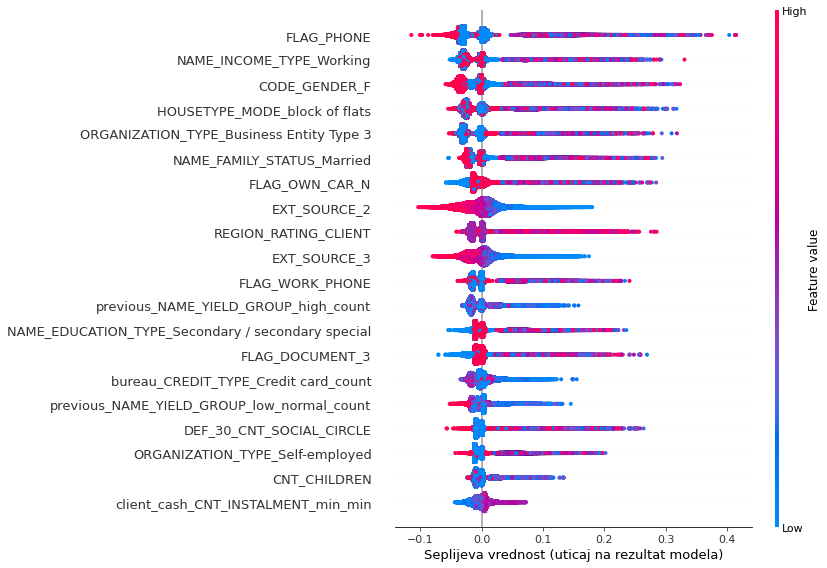

In [46]:
shap.summary_plot(shap_values, X_sm, show=False)
plt.xlabel("Seplijeva vrednost (uticaj na rezultat modela)")
plt.show()